# ChatGPT Reddit Sentiment Analysis

In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.7 MB/s eta 0:00:00


In [2]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import sklearn.model_selection as ms
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import transformers as trfs
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
#Loading data
from google.colab import files
files.upload()
data = pd.read_csv("chatgpt-reddit-comments.csv", index_col='Unnamed: 0')


Saving chatgpt-reddit-comments.csv to chatgpt-reddit-comments.csv


In [4]:
data.head()

,comment_id,comment_parent_id,comment_body,subreddit
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [5]:
#Checking data shape
data.shape

(52416, 4)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52416 entries, 0 to 
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   comment_id         52415 non-null  object
 1   comment_parent_id  52415 non-null  object
 2   comment_body       52415 non-null  object
 3   subreddit          52415 non-null  object
dtypes: object(4)
memory usage: 2.0+ MB


# Checking the data for missing values

In [7]:
data.isnull().sum()

comment_id           1
comment_parent_id    1
comment_body         1
subreddit            1
dtype: int64

In [8]:
data.dropna(inplace = True)
data.isna().sum()

comment_id           0
comment_parent_id    0
comment_body         0
subreddit            0
dtype: int64

# Checking the data distribution according to Subreddit

In [9]:
subreddit_count = data['subreddit'].value_counts()
subreddit_count

r/ChatGPT            29711
r/technology         16672
r/Futurology          5009
r/dataisbeautiful     1020
subreddit                3
Name: subreddit, dtype: int64

In [10]:
parent_comment = data['comment_parent_id'].value_counts()
parent_comment

t3_107vs7i    239
t3_109g9gf    223
t3_10mias6    216
t3_10heg9p    208
t3_ztd950     202
             ... 
t1_j59syw8      1
t1_j59o2s4      1
t1_j59y2i8      1
t1_j5dhf8u      1
t1_j5m6aj0      1
Name: comment_parent_id, Length: 22596, dtype: int64

Text(0.5, 1.0, 'Comment Frequency by Subreddits')

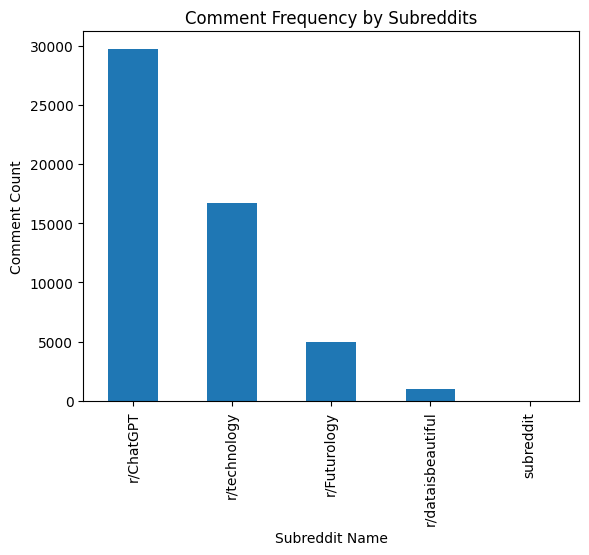

In [11]:
subreddit_count.plot(kind='bar')
plt.xlabel("Subreddit Name")
plt.ylabel("Comment Count")
plt.title("Comment Frequency by Subreddits")

In [12]:
data.comment_body[15]

'Shit it worked on me'

# Plotting WordCloud

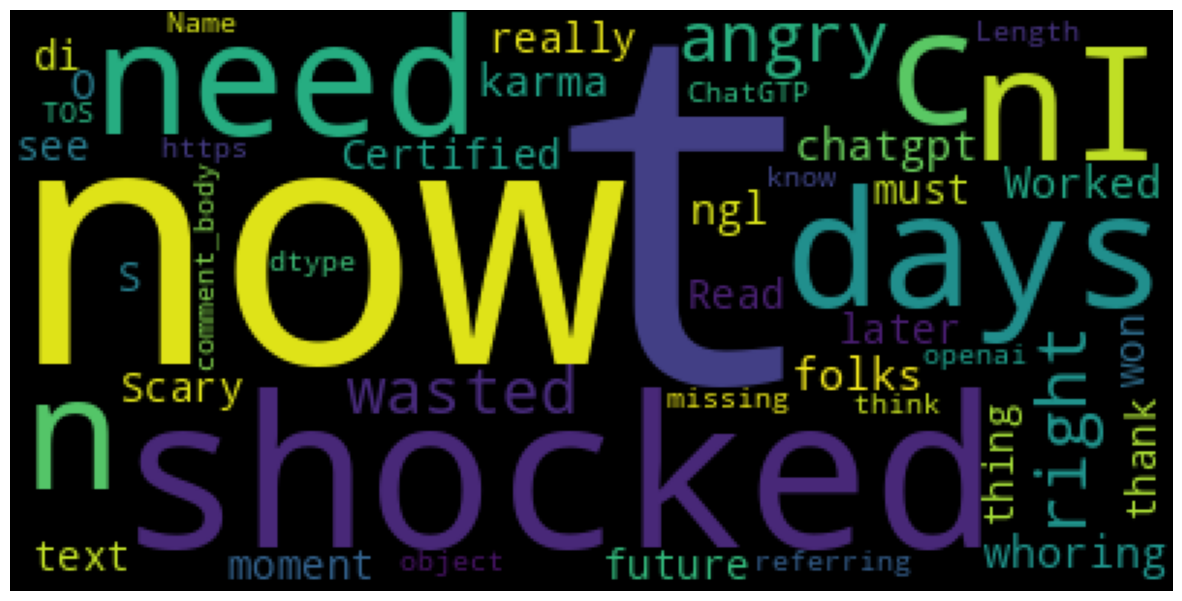

In [13]:
cloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=200).generate(str(data.comment_body))
plt.figure(figsize=(15,10))
plt.clf
plt.imshow(cloud)
plt.axis('off')
plt.show()

# Applying VADER

In [14]:
sid = SentimentIntensityAnalyzer()

In [15]:
data['scores'] = data['comment_body'].apply(lambda comment_body: sid.polarity_scores(comment_body))
data.head()

,comment_id,comment_parent_id,comment_body,subreddit,scores
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,"{'neg': 0.223, 'neu': 0.777, 'pos': 0.0, 'comp..."
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,"{'neg': 0.201, 'neu': 0.734, 'pos': 0.065, 'co..."
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,"{'neg': 0.151, 'neu': 0.725, 'pos': 0.124, 'co..."
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,"{'neg': 0.207, 'neu': 0.793, 'pos': 0.0, 'comp..."


In [16]:
data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
data.head()

,comment_id,comment_parent_id,comment_body,subreddit,scores,compound
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,"{'neg': 0.223, 'neu': 0.777, 'pos': 0.0, 'comp...",-0.3182
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,"{'neg': 0.201, 'neu': 0.734, 'pos': 0.065, 'co...",-0.9837
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,"{'neg': 0.151, 'neu': 0.725, 'pos': 0.124, 'co...",-0.2001
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,"{'neg': 0.207, 'neu': 0.793, 'pos': 0.0, 'comp...",-0.4364


# Generating a Function to label the sentiment according to compound score

In [17]:
def get_tag(val):
    if val <= -0.50:
        return "Negative"
    elif val >= 0.5:
        return "Positive"
    else:
        return "Neutral"

In [18]:
data['Sentiment'] = data['compound'].apply(get_tag)
data.head()

,comment_id,comment_parent_id,comment_body,subreddit,scores,compound,Sentiment
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,"{'neg': 0.223, 'neu': 0.777, 'pos': 0.0, 'comp...",-0.3182,Neutral
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,"{'neg': 0.201, 'neu': 0.734, 'pos': 0.065, 'co...",-0.9837,Negative
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,"{'neg': 0.151, 'neu': 0.725, 'pos': 0.124, 'co...",-0.2001,Neutral
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,"{'neg': 0.207, 'neu': 0.793, 'pos': 0.0, 'comp...",-0.4364,Neutral


In [19]:
# Dropping the scores and compound columns from the dataframe
data.drop(['scores', 'compound'], axis=1, inplace=True)

In [20]:
data.head(10)

,comment_id,comment_parent_id,comment_body,subreddit,Sentiment
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,Neutral
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,Negative
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Neutral
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,Neutral
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,Neutral
5,izw8iw3,t3_zj2aeu,"Wow, way to discover the most basic functional...",r/ChatGPT,Positive
6,izvxxi8,t3_zj2aeu,"People on Reddit seek the karma and the fame,\...",r/ChatGPT,Positive
7,izwe6c7,t3_zj2aeu,Inception)),r/ChatGPT,Neutral
8,iztipoe,t3_zj2aeu,What's the point of even trying to click-bait ...,r/ChatGPT,Neutral
9,izvxsd9,t3_zj2aeu,I love you.,r/ChatGPT,Positive


# Checking the data distribution according to the sentiment labels

In [21]:
sentiment = data['Sentiment'].value_counts()
sentiment

Neutral     32134
Positive    14461
Negative     5820
Name: Sentiment, dtype: int64

Text(0.5, 1.0, 'Sentment Frequenecy')

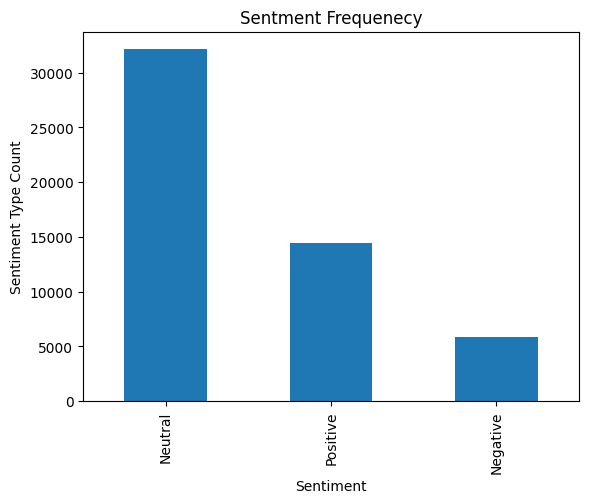

In [22]:
sentiment.plot(kind='bar')
plt.xlabel("Sentiment")
plt.ylabel("Sentiment Type Count")
plt.title("Sentment Frequenecy")

# Replacing Sentiment labels with integers for processing

In [23]:
data.to_csv('Labeled Data.csv')

data_labeled = pd.read_csv('Labeled Data.csv')
data_labeled['Sentment'] = data_labeled['Sentiment'].replace(['Negative', 'Positive', 'Neutral'], [-1, 1, 0], inplace=True)

# Initializing the BERT model for Training

In [24]:
# Max length of encoded string this includes special tokens such as [CLS] and [SEP]
MAX_SEQUENCE_LENGTH = 64

# BERT model with lowercase chars only:
PRETRAINED_MODEL_NAME = 'bert-base-uncased' 

# Defining the Batch size to use during training:
BATCH_SIZE = 128

# Number of epochs:
EPOCHS = 4

In [25]:
# Creating a function for BERT model building
def create_model(max_sequence, model_name, num_labels):
    bert_model = trfs.TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence,), dtype=tf.int32, name='input_ids')

    attention_mask = tf.keras.layers.Input((max_sequence,), dtype=tf.int32, name='attention_mask')
    
    output = bert_model([input_ids, attention_mask])[0]

    output = tf.keras.layers.Dense(num_labels, activation='softmax')(output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

In [26]:
model = create_model(MAX_SEQUENCE_LENGTH, PRETRAINED_MODEL_NAME, 3)

opt = tf.keras.optimizers.Adam(learning_rate=3e-5) # Selecting the optimzer and learning rate
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall']) # Compiling model with optimizer, loss function and performance metrics

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Defining a function for tokenization
def batch_encode(X, tokenizer):
    return tokenizer.batch_encode_plus(
    X,
    max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    pad_to_max_length=True, # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)

In [28]:
tokenizer = trfs.BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109484547  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]']         
 fication)                      logits=(None, 3),                                                 
                                 hidden_states=None                                           

# Splitting the data between train and test

In [30]:
X_train, X_val, y_train, y_val = ms.train_test_split(data_labeled.comment_body.values, data_labeled.Sentiment.values, test_size=0.2)

In [31]:
y_train

array([-1,  0, -1, ...,  0,  0,  0])

# Training the BERT Model

In [32]:
# Converting the target column to categorical format in both train/test
y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)

In [33]:
# Tokenizing the input data in both train/test using the batch_encode function defined above
X_train = batch_encode(X_train, tokenizer)
X_val = batch_encode(X_val, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [34]:
# Training the model
history = model.fit(
    x=X_train.values(),
    y=y_train,
    validation_data=(X_val.values(), y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/4
328/328 [==============================] - 599s 2s/step - loss: 0.5704 - accuracy: 0.7511 - precision: 0.7799 - recall: 0.7060 - val_loss: 0.4361 - val_accuracy: 0.8124 - val_precision: 0.8376 - val_recall: 0.7845
Epoch 2/4
328/328 [==============================] - 555s 2s/step - loss: 0.3731 - accuracy: 0.8446 - precision: 0.8643 - recall: 0.8222 - val_loss: 0.4011 - val_accuracy: 0.8305 - val_precision: 0.8433 - val_recall: 0.8169
Epoch 3/4
328/328 [==============================] - 555s 2s/step - loss: 0.2778 - accuracy: 0.8876 - precision: 0.9025 - recall: 0.8726 - val_loss: 0.4159 - val_accuracy: 0.8332 - val_precision: 0.8447 - val_recall: 0.8221
Epoch 4/4
328/328 [==============================] - 555s 2s/step - loss: 0.2068 - accuracy: 0.9185 - precision: 0.9281 - recall: 0.9089 - val_loss: 0.4724 - val_accuracy: 0.8272 - val_precision: 0.8382 - val_recall: 0.8162


# Plotting Model Accuracy, Loss, Precision, Recall and Confusion Matrix

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


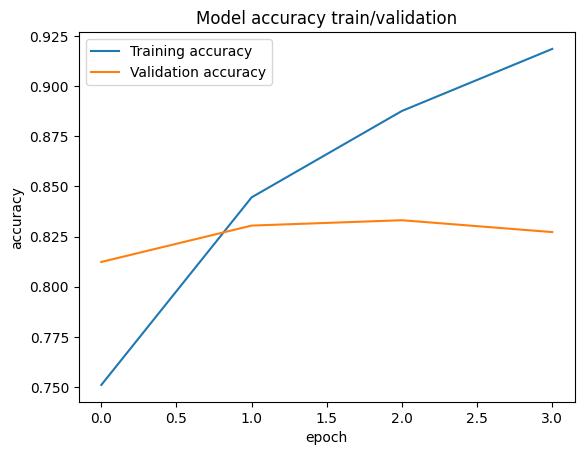

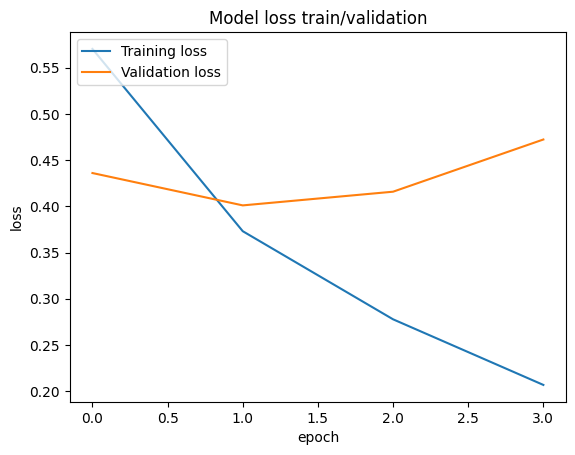

In [35]:
# list the metrics names used during training/validation
print(history.history.keys())

# Plotting model accuracy for both training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy train/validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
plt.show()


# Plotting model loss for both training and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss train/validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

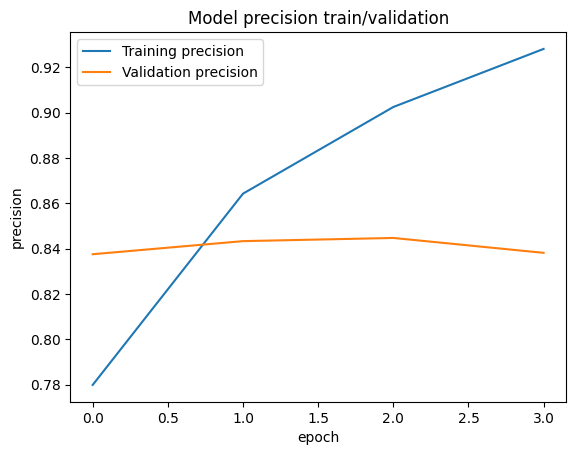

In [36]:
# Plotting model precision for both training and validation
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision train/validation')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['Training precision', 'Validation precision'], loc='upper left')
plt.show()

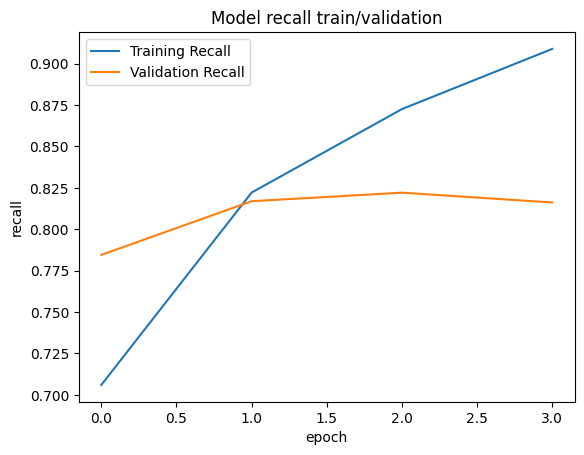

In [37]:
# Plotting model precision for both training and validation
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall train/validation')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['Training Recall', 'Validation Recall'], loc='upper left')
plt.show()

In [38]:
y_pred = model.predict(X_val.values())

328/328 [==============================] - 48s 136ms/step


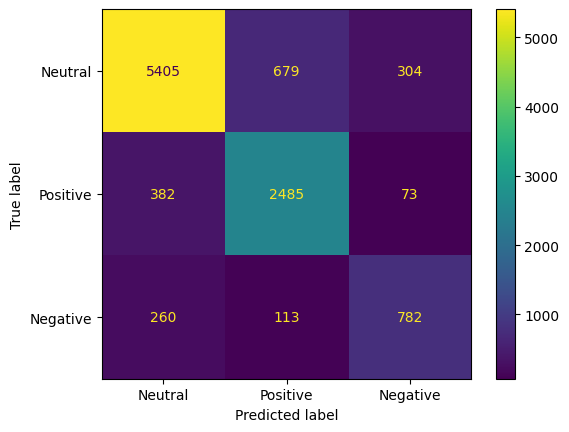

In [39]:
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_val, axis=1)
matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(matrix, display_labels = ['Neutral', 'Positive', 'Negative'])
disp.plot()


# References
https://datafai.com/simple-wordcloud-using-nltk-library-in-python/

https://github.com/cjhutto/vaderSentiment

https://arxiv.org/abs/1810.04805

https://huggingface.co/bert-base-uncased

https://stackoverflow.com/questions/60463829/training-tfbertforsequenceclassification-with-custom-x-and-y-data

https://www.kaggle.com/code/prakharrathi25/sentiment-analysis-using-bert

https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
